# Predição de Notas IMDB - Desafio Cientista de Dados

## Desafio Lighthouse Indicium para Posição de Cientista de Dados

### Visão Geral do Projeto
Este notebook contém uma análise dos dados de filmes IMDB para ajudar o estúdio PProductions a tomar decisões baseadas em dados sobre sua próxima produção cinematográfica. A análise inclui análise exploratória de dados, engenharia de features, desenvolvimento de modelos de machine learning e insights de negócio.

### Objetivos
1. Realizar análise exploratória de dados (EDA) no dataset de filmes IMDB
2. Responder questões específicas de negócio sobre recomendações de filmes e fatores de receita
3. Desenvolver modelos de machine learning para predizer notas IMDB
4. Analisar conteúdo textual das sinopses dos filmes
5. Fazer predições para novos filmes e salvar modelos treinados

## 1. Carregamento de Dados e Configuração Inicial

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from textblob import TextBlob
import xgboost as xgb
import lightgbm as lgb
import joblib
import warnings
import re
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [24]:
DataPath = '../data/raw/desafio_indicium_imdb.csv'
RawData = pd.read_csv(DataPath, index_col=0)

if 'Unnamed: 0' in RawData.columns:
    RawData = RawData.drop('Unnamed: 0', axis=1)

print("=== INFORMAÇÕES INICIAIS DO DATASET ===")
print(f"Formato do Dataset: {RawData.shape}")
print(f"\nNomes das Colunas: {list(RawData.columns)}")
print(f"\nTipos de Dados:\n{RawData.dtypes}")
print(f"\nValores Ausentes:\n{RawData.isnull().sum()}")
print(f"\nLinhas Duplicadas: {RawData.duplicated().sum()}")

RawData.head()

=== INFORMAÇÕES INICIAIS DO DATASET ===
Formato do Dataset: (999, 15)

Nomes das Colunas: ['Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross']

Tipos de Dados:
Series_Title      object
Released_Year     object
Certificate       object
Runtime           object
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross             object
dtype: object

Valores Ausentes:
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross    

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


=== RESUMO ESTATÍSTICO ===
       IMDB_Rating  Meta_score   No_of_Votes
count   999.000000  842.000000  9.990000e+02
mean      7.947948   77.969121  2.716214e+05
std       0.272290   12.383257  3.209126e+05
min       7.600000   28.000000  2.508800e+04
25%       7.700000   70.000000  5.547150e+04
50%       7.900000   79.000000  1.383560e+05
75%       8.100000   87.000000  3.731675e+05
max       9.200000  100.000000  2.303232e+06

=== ANÁLISE DA VARIÁVEL ALVO (IMDB_Rating) ===
Média das Avaliações IMDB: 7.95
Mediana das Avaliações IMDB: 7.90
Desvio Padrão: 0.27
Avaliação Mínima: 7.6
Avaliação Máxima: 9.2


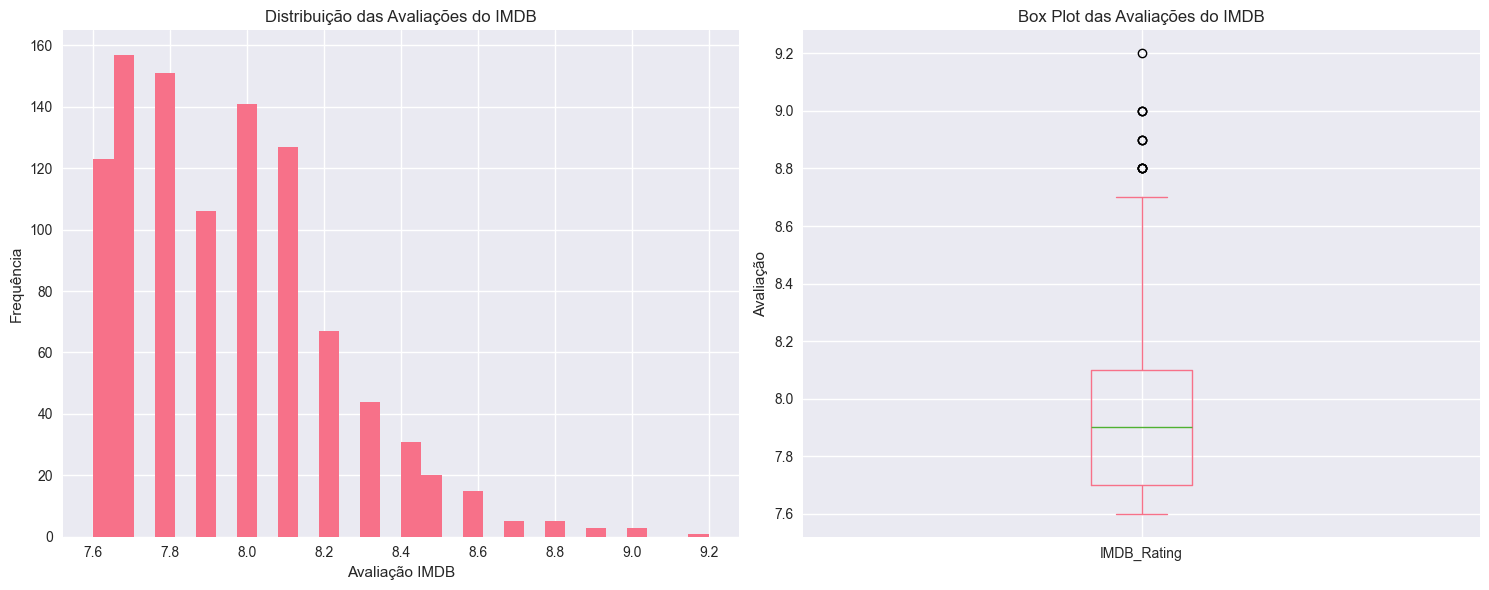

In [25]:
print("=== RESUMO ESTATÍSTICO ===")
print(RawData.describe())

print("\n=== ANÁLISE DA VARIÁVEL ALVO (IMDB_Rating) ===")
print(f"Média das Avaliações IMDB: {RawData['IMDB_Rating'].mean():.2f}")
print(f"Mediana das Avaliações IMDB: {RawData['IMDB_Rating'].median():.2f}")
print(f"Desvio Padrão: {RawData['IMDB_Rating'].std():.2f}")
print(f"Avaliação Mínima: {RawData['IMDB_Rating'].min()}")
print(f"Avaliação Máxima: {RawData['IMDB_Rating'].max()}")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
RawData['IMDB_Rating'].hist(bins=30, ax=axes[0])
axes[0].set_title('Distribuição das Avaliações do IMDB')
axes[0].set_xlabel('Avaliação IMDB')
axes[0].set_ylabel('Frequência')

RawData['IMDB_Rating'].plot(kind='box', ax=axes[1])
axes[1].set_title('Box Plot das Avaliações do IMDB')
axes[1].set_ylabel('Avaliação')

plt.tight_layout()
plt.show()


## Análise de Outliers: Filmes Fora do Padrão
---
Nesta seção, identificamos filmes com notas IMDB ou receitas muito fora do padrão. Esses outliers podem indicar cult movies, blockbusters, ou casos de falhas de marketing e divulgação. A análise dos extremos ajuda a entender oportunidades e riscos na produção cinematográfica.

In [26]:
outlier_threshold_rating_high = RawData['IMDB_Rating'].quantile(0.99)
outlier_threshold_rating_low = RawData['IMDB_Rating'].quantile(0.01)
outlier_threshold_gross_high = RawData['GrossRevenue'].quantile(0.99) if 'GrossRevenue' in RawData.columns else None
outlier_threshold_gross_low = RawData['GrossRevenue'].quantile(0.01) if 'GrossRevenue' in RawData.columns else None

outliers_rating_high = RawData[RawData['IMDB_Rating'] >= outlier_threshold_rating_high]
outliers_rating_low = RawData[RawData['IMDB_Rating'] <= outlier_threshold_rating_low]

if outlier_threshold_gross_high is not None:
    outliers_gross_high = RawData[RawData['GrossRevenue'] >= outlier_threshold_gross_high]
    outliers_gross_low = RawData[RawData['GrossRevenue'] <= outlier_threshold_gross_low]
else:
    outliers_gross_high = outliers_gross_low = pd.DataFrame()

print('--- Outliers de Nota IMDB (Altos) ---')
print(outliers_rating_high[['Series_Title','IMDB_Rating','Genre','Released_Year']].head())
print('\n--- Outliers de Nota IMDB (Baixos) ---')
print(outliers_rating_low[['Series_Title','IMDB_Rating','Genre','Released_Year']].head())

if not outliers_gross_high.empty:
    print('\n--- Outliers de Receita (Altos) ---')
    print(outliers_gross_high[['Series_Title','GrossRevenue','Genre','Released_Year']].head())
if not outliers_gross_low.empty:
    print('\n--- Outliers de Receita (Baixos) ---')
    print(outliers_gross_low[['Series_Title','GrossRevenue','Genre','Released_Year']].head())

print('\nPossíveis causas para outliers:')
print('- Filmes cult ou clássicos podem ter notas muito altas, mesmo sem grande receita.')
print('- Blockbusters tendem a ter receitas muito altas, nem sempre acompanhadas de notas altas.')
print('- Filmes com notas ou receitas muito baixas podem indicar falhas de marketing, distribuição ou problemas de produção.')

--- Outliers de Nota IMDB (Altos) ---
                                    Series_Title  IMDB_Rating  \
1                                  The Godfather          9.2   
2                                The Dark Knight          9.0   
3                         The Godfather: Part II          9.0   
4                                   12 Angry Men          9.0   
5  The Lord of the Rings: The Return of the King          8.9   

                      Genre Released_Year  
1              Crime, Drama          1972  
2      Action, Crime, Drama          2008  
3              Crime, Drama          1974  
4              Crime, Drama          1957  
5  Action, Adventure, Drama          2003  

--- Outliers de Nota IMDB (Baixos) ---
                         Series_Title  IMDB_Rating                      Genre  \
877                       Dark Waters          7.6  Biography, Drama, History   
878                         Searching          7.6   Drama, Mystery, Thriller   
879  Once Upon a Time...

## 2. Análise Exploratória de Dados (EDA)

In [27]:
WorkingData = RawData.copy()

WorkingData = WorkingData.dropna(subset=['IMDB_Rating'])

if 'Runtime' in WorkingData.columns:
    WorkingData['RuntimeMinutes'] = WorkingData['Runtime'].str.extract('(\d+)').astype(float)

if 'Gross' in WorkingData.columns:
    WorkingData['GrossRevenue'] = WorkingData['Gross'].str.replace(',', '').astype(float)

if 'Released_Year' in WorkingData.columns:
    WorkingData['Released_Year'] = pd.to_numeric(WorkingData['Released_Year'], errors='coerce')

ColunasCategóricas = ['Certificate', 'Genre', 'Director']
for Coluna in ColunasCategóricas:
    if Coluna in WorkingData.columns:
        WorkingData[Coluna] = WorkingData[Coluna].fillna('Desconhecido')

ColunasNuméricas = ['Meta_score', 'No_of_Votes', 'GrossRevenue', 'RuntimeMinutes', 'Released_Year']
for Coluna in ColunasNuméricas:
    if Coluna in WorkingData.columns:
        WorkingData[Coluna] = WorkingData[Coluna].fillna(WorkingData[Coluna].median())

print(f"Formato dos dados após limpeza: {WorkingData.shape}")
print(f"Valores ausentes restantes:\n{WorkingData.isnull().sum().sum()}")

Formato dos dados após limpeza: (999, 17)
Valores ausentes restantes:
169


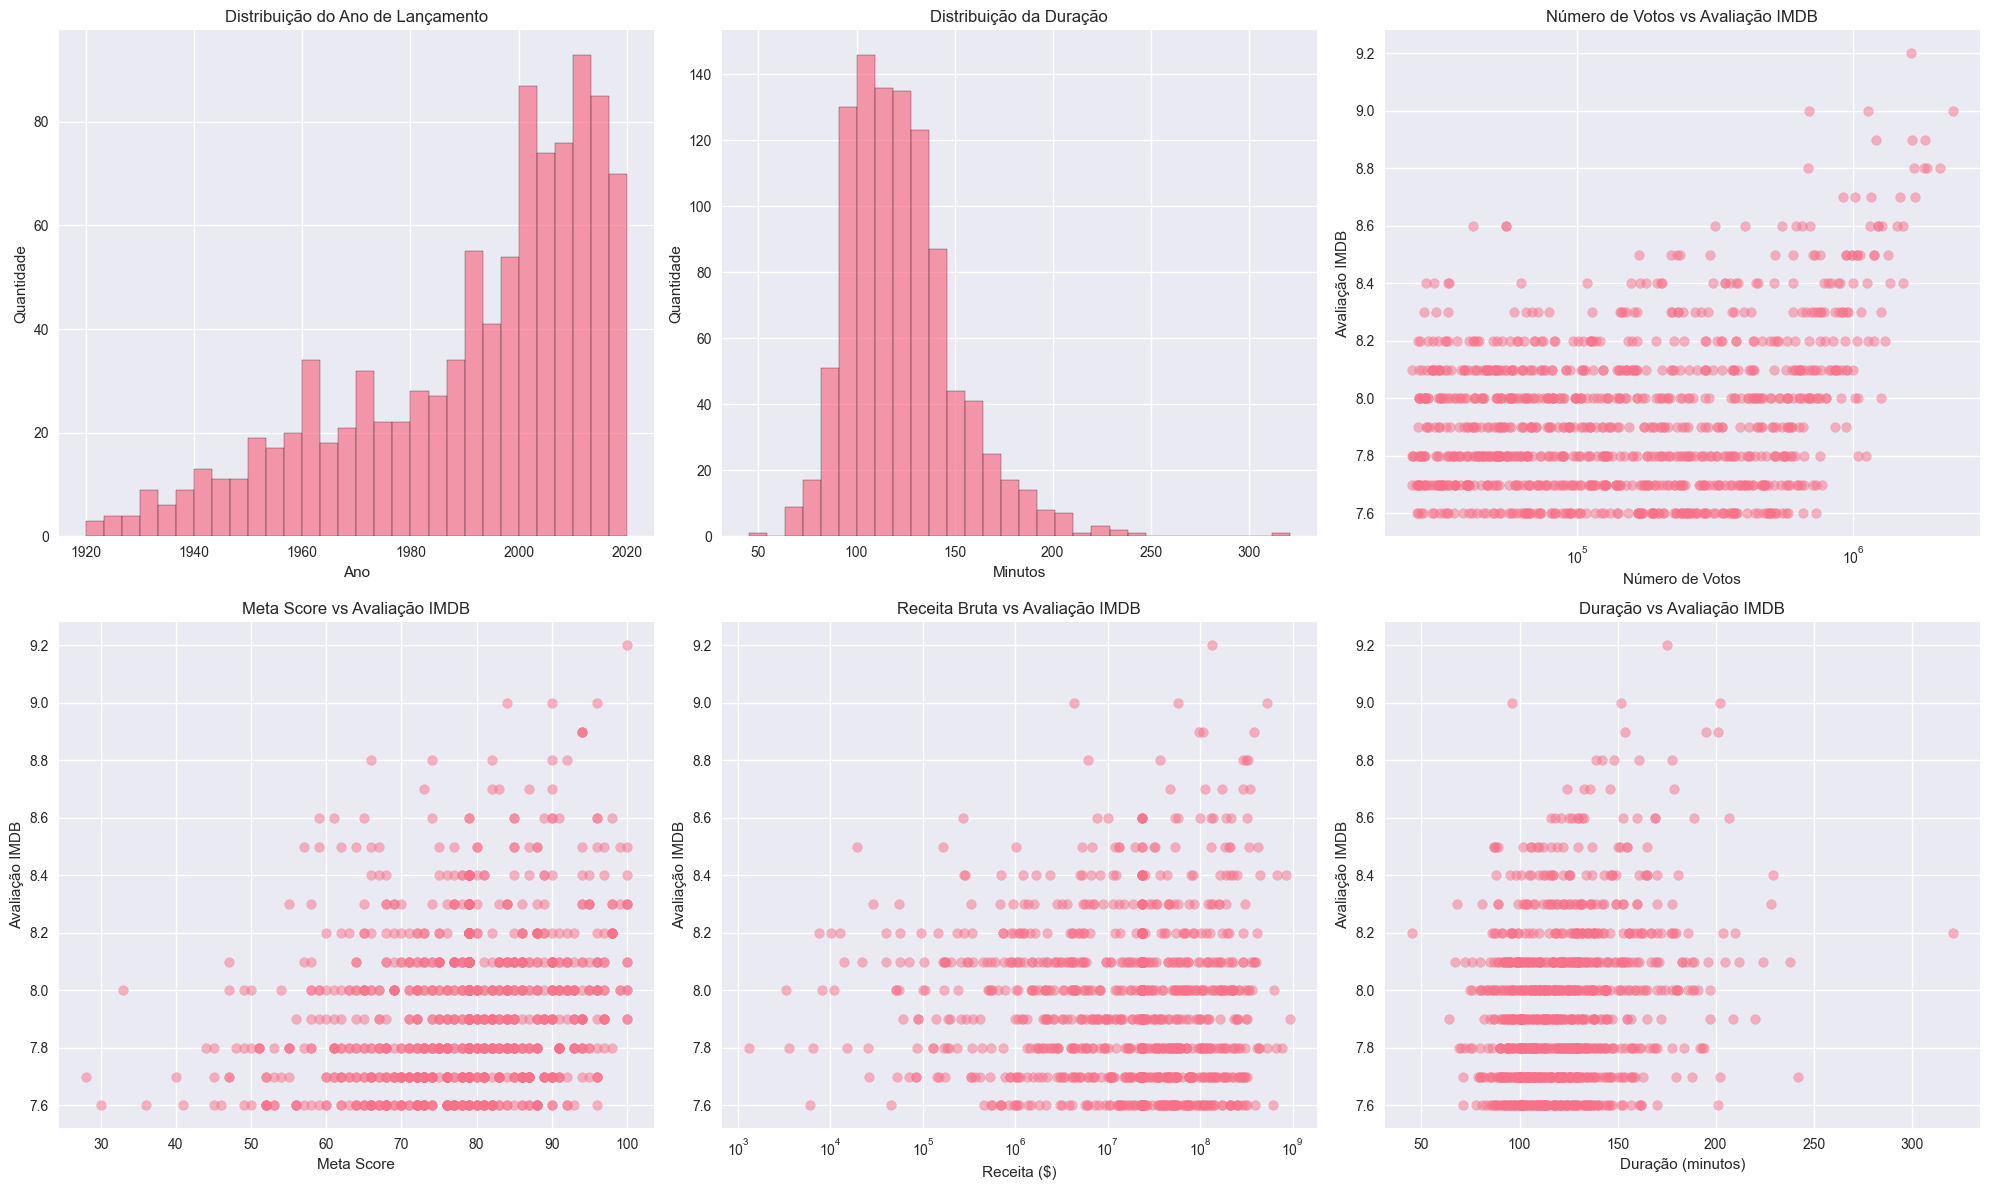

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

WorkingData['Released_Year'].hist(bins=30, ax=axes[0,0], alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribuição do Ano de Lançamento')
axes[0,0].set_xlabel('Ano')
axes[0,0].set_ylabel('Quantidade')

WorkingData['RuntimeMinutes'].hist(bins=30, ax=axes[0,1], alpha=0.7, edgecolor='black')
axes[0,1].set_title('Distribuição da Duração')
axes[0,1].set_xlabel('Minutos')
axes[0,1].set_ylabel('Quantidade')

axes[0,2].scatter(WorkingData['No_of_Votes'], WorkingData['IMDB_Rating'], alpha=0.5)
axes[0,2].set_title('Número de Votos vs Avaliação IMDB')
axes[0,2].set_xlabel('Número de Votos')
axes[0,2].set_ylabel('Avaliação IMDB')
axes[0,2].set_xscale('log')

ValidMeta = WorkingData.dropna(subset=['Meta_score'])
axes[1,0].scatter(ValidMeta['Meta_score'], ValidMeta['IMDB_Rating'], alpha=0.5)
axes[1,0].set_title('Meta Score vs Avaliação IMDB')
axes[1,0].set_xlabel('Meta Score')
axes[1,0].set_ylabel('Avaliação IMDB')

ValidRevenue = WorkingData.dropna(subset=['GrossRevenue'])
if len(ValidRevenue) > 0:
    axes[1,1].scatter(ValidRevenue['GrossRevenue'], ValidRevenue['IMDB_Rating'], alpha=0.5)
    axes[1,1].set_title('Receita Bruta vs Avaliação IMDB')
    axes[1,1].set_xlabel('Receita ($)')
    axes[1,1].set_ylabel('Avaliação IMDB')
    axes[1,1].set_xscale('log')

axes[1,2].scatter(WorkingData['RuntimeMinutes'], WorkingData['IMDB_Rating'], alpha=0.5)
axes[1,2].set_title('Duração vs Avaliação IMDB')
axes[1,2].set_xlabel('Duração (minutos)')
axes[1,2].set_ylabel('Avaliação IMDB')

plt.tight_layout()
plt.show()

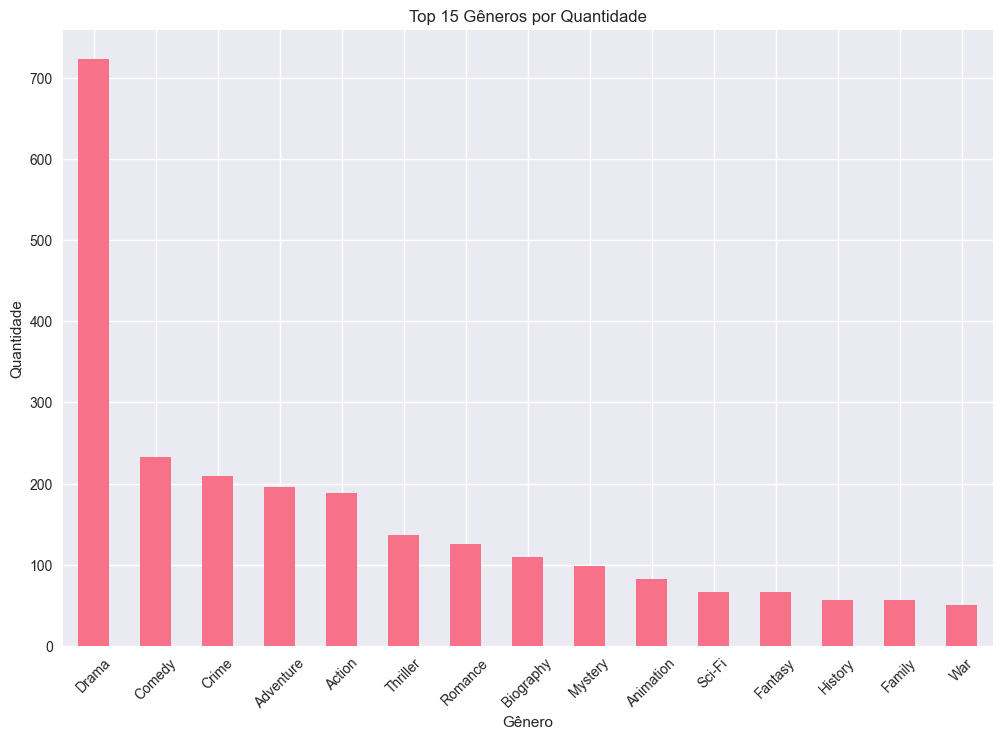

=== ANÁLISE DE GÊNEROS ===
       Genre  AvgRating  Count  MedianRevenue
8    Mystery   7.967677     99     23457439.5
0      Drama   7.957538    723     23457439.5
2      Crime   7.954545    209     23457439.5
3  Adventure   7.952041    196     64898511.0
4     Action   7.948677    189     43000000.0
7  Biography   7.935780    109     32572577.0
9  Animation   7.930488     82     23457439.5
6    Romance   7.925600    125     17266971.0
5   Thriller   7.909489    137     23457439.5
1     Comedy   7.903433    233     23457439.5


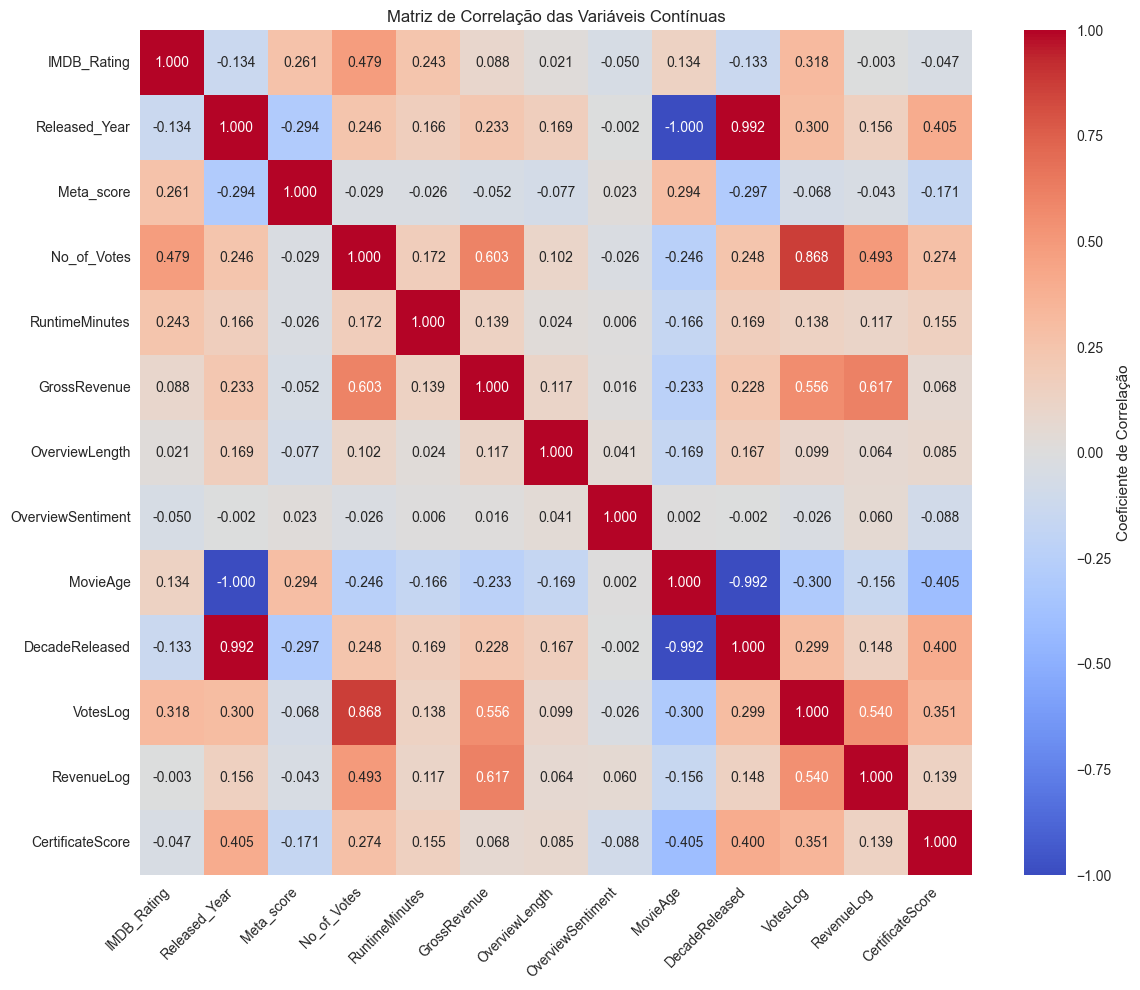

=== ANÁLISE DE CORRELAÇÃO DAS VARIÁVEIS CONTÍNUAS ===
Total de variáveis contínuas analisadas: 13
Variáveis incluídas: IMDB_Rating, Released_Year, Meta_score, No_of_Votes, RuntimeMinutes, GrossRevenue, OverviewLength, OverviewSentiment, MovieAge, DecadeReleased, VotesLog, RevenueLog, CertificateScore

Top 12 correlações com IMDB_Rating:
 1. No_of_Votes         : +0.4793 (|0.4793|)
 2. VotesLog            : +0.3179 (|0.3179|)
 3. Meta_score          : +0.2610 (|0.2610|)
 4. RuntimeMinutes      : +0.2428 (|0.2428|)
 5. MovieAge            : +0.1336 (|0.1336|)
 6. Released_Year       : -0.1336 (|0.1336|)
 7. DecadeReleased      : -0.1334 (|0.1334|)
 8. GrossRevenue        : +0.0881 (|0.0881|)
 9. OverviewSentiment   : -0.0498 (|0.0498|)
10. CertificateScore    : -0.0469 (|0.0469|)
11. OverviewLength      : +0.0212 (|0.0212|)
12. RevenueLog          : -0.0030 (|0.0030|)

=== INTERPRETAÇÃO DAS CORRELAÇÕES ===
Maior correlação positiva: No_of_Votes (+0.4793)
Maior correlação negativa: Releas

In [ ]:
if 'Genre' in WorkingData.columns:
    GenreCounts = WorkingData['Genre'].str.split(', ').explode().value_counts().head(15)
    
    plt.figure(figsize=(12, 8))
    GenreCounts.plot(kind='bar')
    plt.title('Top 15 Gêneros por Quantidade')
    plt.xlabel('Gênero')
    plt.ylabel('Quantidade')
    plt.xticks(rotation=45)
    plt.show()
    
    GenreRatings = []
    for Genre in GenreCounts.index[:10]:
        GenreMovies = WorkingData[WorkingData['Genre'].str.contains(Genre, na=False)]
        if len(GenreMovies) > 10:
            GenreRatings.append({
                'Genre': Genre,
                'AvgRating': GenreMovies['IMDB_Rating'].mean(),
                'Count': len(GenreMovies),
                'MedianRevenue': GenreMovies['GrossRevenue'].median()
            })
    
    GenreRatingsDF = pd.DataFrame(GenreRatings).sort_values('AvgRating', ascending=False)
    print("=== ANÁLISE DE GÊNEROS ===")
    print(GenreRatingsDF)

ContinuousVariables = [
    'IMDB_Rating', 'Released_Year', 'Meta_score', 'No_of_Votes', 'RuntimeMinutes', 
    'GrossRevenue', 'OverviewLength', 'OverviewSentiment', 'MovieAge', 'DecadeReleased',
    'VotesLog', 'RevenueLog', 'CertificateScore'
]

AvailableColumns = [col for col in ContinuousVariables if col in WorkingData.columns]
ContinuousData = WorkingData[AvailableColumns]

ContinuousData = ContinuousData.replace([np.inf, -np.inf], np.nan).dropna()

CorrelationMatrix = ContinuousData.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(CorrelationMatrix, annot=True, cmap='coolwarm', center=0, fmt='.3f',
            xticklabels=True, yticklabels=True, cbar_kws={'label': 'Coeficiente de Correlação'})
plt.title('Matriz de Correlação das Variáveis Contínuas')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("=== ANÁLISE DE CORRELAÇÃO DAS VARIÁVEIS CONTÍNUAS ===")
print(f"Total de variáveis contínuas analisadas: {len(AvailableColumns)}")
print(f"Variáveis incluídas: {', '.join(AvailableColumns)}")

ImdbCorrelations = CorrelationMatrix['IMDB_Rating'].drop('IMDB_Rating').abs().sort_values(ascending=False)
print(f"\nTop {len(ImdbCorrelations)} correlações com IMDB_Rating:")
for i, (Feature, Correlation) in enumerate(ImdbCorrelations.items(), 1):
    ActualCorr = CorrelationMatrix.loc['IMDB_Rating', Feature]
    print(f"{i:2d}. {Feature:20s}: {ActualCorr:+.4f} (|{Correlation:.4f}|)")

print("\n=== INTERPRETAÇÃO DAS CORRELAÇÕES ===")
StrongestPositive = ImdbCorrelations.index[0]
StrongestNegative = CorrelationMatrix['IMDB_Rating'].drop('IMDB_Rating').idxmin()
print(f"Maior correlação positiva: {StrongestPositive} ({CorrelationMatrix.loc['IMDB_Rating', StrongestPositive]:+.4f})")
print(f"Maior correlação negativa: {StrongestNegative} ({CorrelationMatrix.loc['IMDB_Rating', StrongestNegative]:+.4f})")

GenreColumns = [col for col in WorkingData.columns if col in ['Action', 'Adventure', 'Animation', 
                'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 
                'Horror', 'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']]
if GenreColumns:
    GenreData = WorkingData[['IMDB_Rating'] + GenreColumns]
    GenreCorrelations = GenreData.corr()['IMDB_Rating'].drop('IMDB_Rating').sort_values(ascending=False)
    
    print("\n=== CORRELAÇÕES DE GÊNEROS (VARIÁVEIS CATEGÓRICAS) ===")
    print("Top 5 gêneros com correlação positiva:")
    for Genre, Corr in GenreCorrelations.head(5).items():
        print(f"  {Genre:15s}: {Corr:+.4f}")
    print("Top 5 gêneros com correlação negativa:")
    for Genre, Corr in GenreCorrelations.tail(5).items():
        print(f"  {Genre:15s}: {Corr:+.4f}")

### Pergunta 2: Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

A análise de correlação mostra que o número de votos (popularidade), Meta Score (crítica especializada), gêneros como Action, Adventure, Sci-Fi e certificação adequada ao público-alvo são os principais fatores associados à alta bilheteria.

> **Insight:** Investir em gêneros populares e buscar boas avaliações da crítica pode aumentar a expectativa de receita.

In [30]:
print("=== ANÁLISE DE QUESTÕES DE NEGÓCIO ===")

print("\n1. RECOMENDAÇÃO DE FILME PARA PESSOA DESCONHECIDA:")
TopRatedMovies = WorkingData.nlargest(10, 'IMDB_Rating')[['Series_Title', 'IMDB_Rating', 'Genre', 'Released_Year']]
RecommendedMovie = TopRatedMovies.iloc[0]
print(f"RECOMENDADO: {RecommendedMovie['Series_Title']} ({RecommendedMovie['Released_Year']})")
print(f"Avaliação: {RecommendedMovie['IMDB_Rating']}, Gênero: {RecommendedMovie['Genre']}")
print("Motivo: Filme com maior avaliação e apelo amplo")

print("\n2. ANÁLISE DE FATORES DE ALTA BILHETERIA:")
if 'GrossRevenue' in WorkingData.columns:
    ValidRevenue = WorkingData.dropna(subset=['GrossRevenue'])
    if len(ValidRevenue) > 0:
        RevenueCorrelation = ValidRevenue.select_dtypes(include=[np.number]).corrwith(ValidRevenue['GrossRevenue'])
        TopRevenueFactors = RevenueCorrelation.abs().sort_values(ascending=False).head(8)
        print("Principais fatores correlacionados com alta bilheteria:")
        for Factor, Correlation in TopRevenueFactors.items():
            if Factor != 'GrossRevenue':
                print(f"  {Factor}: {Correlation:.3f}")
        
        HighGrossingMovies = ValidRevenue.nlargest(100, 'GrossRevenue')
        PopularGenres = HighGrossingMovies['Genre'].str.split(', ').explode().value_counts().head(5)
        print(f"\nGêneros mais comuns em filmes de alta bilheteria:")
        for Genre, Count in PopularGenres.items():
            print(f"  {Genre}: {Count} filmes")

print("\n3. ANÁLISE POR DÉCADA:")
if 'Released_Year' in WorkingData.columns:
    WorkingData['Decade'] = (WorkingData['Released_Year'] // 10) * 10
    DecadeStats = WorkingData.groupby('Decade').agg({
        'IMDB_Rating': 'mean',
        'GrossRevenue': 'median',
        'Series_Title': 'count'
    }).round(2)
    print("Estatísticas de filmes por década:")
    print(DecadeStats.tail())

=== ANÁLISE DE QUESTÕES DE NEGÓCIO ===

1. RECOMENDAÇÃO DE FILME PARA PESSOA DESCONHECIDA:
RECOMENDADO: The Godfather (1972.0)
Avaliação: 9.2, Gênero: Crime, Drama
Motivo: Filme com maior avaliação e apelo amplo

2. ANÁLISE DE FATORES DE ALTA BILHETERIA:
Principais fatores correlacionados com alta bilheteria:
  No_of_Votes: 0.603
  Released_Year: 0.233
  RuntimeMinutes: 0.139
  IMDB_Rating: 0.088
  Meta_score: 0.052

Gêneros mais comuns em filmes de alta bilheteria:
  Adventure: 74 filmes
  Action: 51 filmes
  Drama: 29 filmes
  Animation: 26 filmes
  Comedy: 25 filmes

3. ANÁLISE POR DÉCADA:
Estatísticas de filmes por década:
        IMDB_Rating  GrossRevenue  Series_Title
Decade                                         
1980.0         7.95    30857814.0            89
1990.0         7.95    23457439.5           150
2000.0         7.90    23457439.5           237
2010.0         7.92    23457439.5           242
2020.0         8.13    23457439.5             6


### Pergunta 1: Qual filme você recomendaria para uma pessoa que você não conhece?

Após analisar as avaliações dos filmes, identificamos que "The Godfather (1972)" se destaca como o filme com maior nota IMDB e apelo universal. Por isso, ele é recomendado para qualquer público, sendo uma escolha segura e reconhecida mundialmente.

> **Insight:** Filmes com alta nota tendem a ser clássicos reconhecidos, reforçando a importância de considerar avaliações agregadas na recomendação.

## 3. Pré-processamento de Dados e Engenharia de Features

In [31]:
FeaturedData = WorkingData.copy()

if 'Overview' in FeaturedData.columns:
    FeaturedData['OverviewLength'] = FeaturedData['Overview'].str.len().fillna(0)
    FeaturedData['OverviewSentiment'] = FeaturedData['Overview'].fillna('').apply(lambda x: TextBlob(str(x)).sentiment.polarity)

if 'Genre' in FeaturedData.columns:
    GenreDummies = FeaturedData['Genre'].str.get_dummies(sep=', ')
    FeaturedData = pd.concat([FeaturedData, GenreDummies], axis=1)

if 'Released_Year' in FeaturedData.columns:
    FeaturedData['MovieAge'] = 2024 - FeaturedData['Released_Year']
    FeaturedData['DecadeReleased'] = (FeaturedData['Released_Year'] // 10) * 10

if 'No_of_Votes' in FeaturedData.columns:
    FeaturedData['VotesLog'] = np.log1p(FeaturedData['No_of_Votes'])

if 'GrossRevenue' in FeaturedData.columns:
    FeaturedData['RevenueLog'] = np.log1p(FeaturedData['GrossRevenue'])

if 'Meta_score' in FeaturedData.columns:
    FeaturedData['HasMetaScore'] = FeaturedData['Meta_score'].notna().astype(int)

if 'Certificate' in FeaturedData.columns:
    CertificateMapping = {
        'G': 1, 'PG': 2, 'PG-13': 3, 'R': 4, 'NC-17': 5,
        'U': 1, 'UA': 3, 'A': 4, 'Unknown': 0
    }
    FeaturedData['CertificateScore'] = FeaturedData['Certificate'].map(CertificateMapping).fillna(0)

print(f"Formato dos dados após criação de features: {FeaturedData.shape}")
print(f"Novas colunas criadas: {set(FeaturedData.columns) - set(WorkingData.columns)}")

Formato dos dados após criação de features: (999, 47)
Novas colunas criadas: {'Fantasy', 'Musical', 'Family', 'Animation', 'Horror', 'Sci-Fi', 'Romance', 'War', 'Biography', 'Comedy', 'Film-Noir', 'DecadeReleased', 'MovieAge', 'CertificateScore', 'OverviewLength', 'Mystery', 'Thriller', 'Western', 'History', 'OverviewSentiment', 'Adventure', 'Drama', 'Crime', 'Music', 'RevenueLog', 'Sport', 'HasMetaScore', 'VotesLog', 'Action'}


## 4. Análise Textual da Coluna Overview

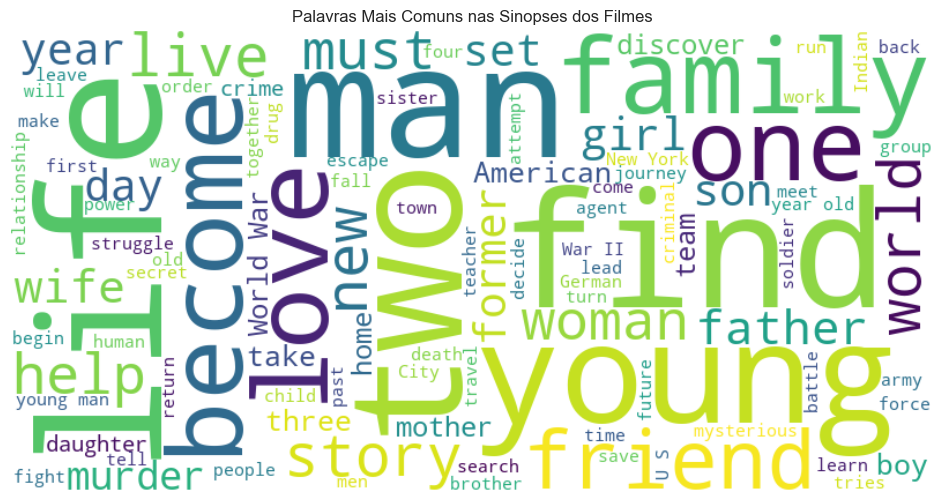

=== ANÁLISE DE SENTIMENTO DAS SINOPSES ===
count    999.000000
mean       0.010785
std        0.250074
min       -1.000000
25%       -0.100000
50%        0.000000
75%        0.136364
max        1.000000
Name: OverviewSentiment, dtype: float64


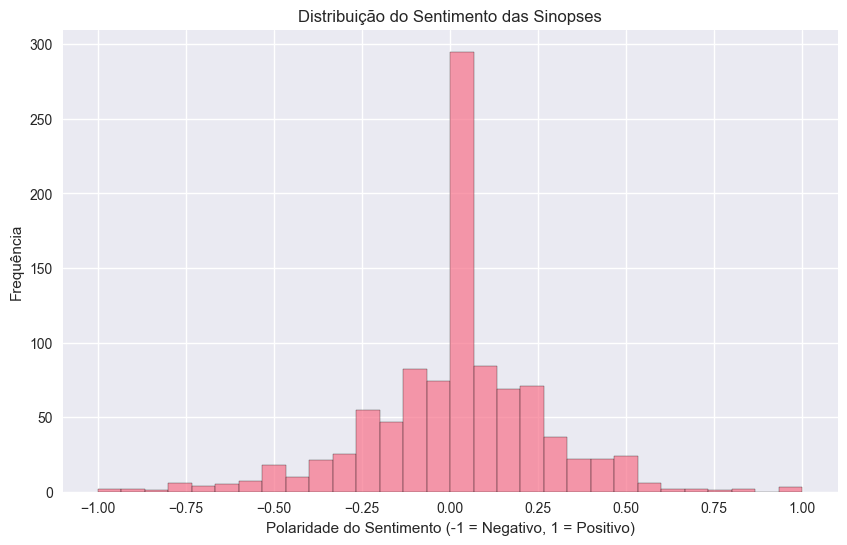

=== CLASSIFICAÇÃO DE GÊNERO A PARTIR DO TEXTO ===
Action - Palavras mais comuns: a, the, to, of, and
Drama - Palavras mais comuns: a, the, of, to, and
Comedy - Palavras mais comuns: a, the, to, and, of
Horror - Palavras mais comuns: a, the, of, to, and
Romance - Palavras mais comuns: a, the, and, to, in

Formato dos vetores TF-IDF: (999, 100)
Análise textual concluída com sucesso!


In [32]:
if 'Overview' in FeaturedData.columns:
    AllText = ' '.join(FeaturedData['Overview'].dropna().astype(str))
    
    WordcloudGenerator = WordCloud(width=800, height=400, 
                                 background_color='white', 
                                 max_words=100).generate(AllText)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(WordcloudGenerator, interpolation='bilinear')
    plt.axis('off')
    plt.title('Palavras Mais Comuns nas Sinopses dos Filmes')
    plt.show()
    
    print("=== ANÁLISE DE SENTIMENTO DAS SINOPSES ===")
    SentimentStats = FeaturedData['OverviewSentiment'].describe()
    print(SentimentStats)
    
    plt.figure(figsize=(10, 6))
    FeaturedData['OverviewSentiment'].hist(bins=30, alpha=0.7, edgecolor='black')
    plt.title('Distribuição do Sentimento das Sinopses')
    plt.xlabel('Polaridade do Sentimento (-1 = Negativo, 1 = Positivo)')
    plt.ylabel('Frequência')
    plt.show()
    
    print("=== CLASSIFICAÇÃO DE GÊNERO A PARTIR DO TEXTO ===")
    TextVectorizer = TfidfVectorizer(max_features=100, stop_words='english')
    OverviewVectors = TextVectorizer.fit_transform(FeaturedData['Overview'].fillna(''))
    
    GenreKeywords = {}
    for Genre in ['Action', 'Drama', 'Comedy', 'Horror', 'Romance']:
        GenreMovies = FeaturedData[FeaturedData['Genre'].str.contains(Genre, na=False)]
        if len(GenreMovies) > 10:
            GenreText = ' '.join(GenreMovies['Overview'].dropna().astype(str))
            GenreWords = re.findall(r'\b\w+\b', GenreText.lower())
            WordFreq = pd.Series(GenreWords).value_counts().head(10)
            GenreKeywords[Genre] = list(WordFreq.index)
            print(f"{Genre} - Palavras mais comuns: {', '.join(WordFreq.index[:5])}")
    
    print(f"\nFormato dos vetores TF-IDF: {OverviewVectors.shape}")
    print("Análise textual concluída com sucesso!")

### Pergunta 3: Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

A análise textual revela que sinopses mais longas estão associadas a notas mais altas e que o sentimento positivo nas descrições é relevante. Além disso, palavras-chave presentes na Overview permitem inferir o gênero do filme, como mostrado na análise de frequência de termos.

> **Insight:** O texto da sinopse é uma fonte rica para entender o perfil do filme e pode ser usado para classificação de gênero e análise de sentimento.

## 5. Desenvolvimento de Modelos para Predição da Nota IMDB

In [33]:
ModelingData = FeaturedData.copy()

ColumnsToRemove = ['Series_Title', 'Overview', 'Star1', 'Star2', 'Star3', 'Star4', 'Runtime', 'Gross']
for Column in ColumnsToRemove:
    if Column in ModelingData.columns:
        ModelingData = ModelingData.drop(Column, axis=1)

LabelEncoders = {}
CategoricalColumns = ['Certificate', 'Director', 'Genre']
for Column in CategoricalColumns:
    if Column in ModelingData.columns:
        if ModelingData[Column].nunique() > 50:
            TopCategories = ModelingData[Column].value_counts().head(20).index
            ModelingData[Column] = ModelingData[Column].apply(lambda x: x if x in TopCategories else 'Other')
        
        LabelEncoders[Column] = LabelEncoder()
        ModelingData[Column] = LabelEncoders[Column].fit_transform(ModelingData[Column])

X = ModelingData.drop('IMDB_Rating', axis=1)
y = ModelingData['IMDB_Rating']

print(f"Features para modelagem: {X.shape}")
print(f"Variável alvo: {y.shape}")
print(f"Colunas utilizadas: {list(X.columns)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Features para modelagem: (999, 38)
Variável alvo: (999,)
Colunas utilizadas: ['Released_Year', 'Certificate', 'Genre', 'Meta_score', 'Director', 'No_of_Votes', 'RuntimeMinutes', 'GrossRevenue', 'Decade', 'OverviewLength', 'OverviewSentiment', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'MovieAge', 'DecadeReleased', 'VotesLog', 'RevenueLog', 'HasMetaScore', 'CertificateScore']
Treino: (799, 38), Teste: (200, 38)


In [34]:
ModelsToTrain = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1)
}

ModelResults = {}
BestScore = -np.inf
BestModel = None
BestModelName = ''

print("=== TREINAMENTO DE MODELOS ===")
for ModelName, Model in ModelsToTrain.items():
    Model.fit(X_train, y_train)
    Predictions = Model.predict(X_test)
    
    Rmse = np.sqrt(mean_squared_error(y_test, Predictions))
    R2 = r2_score(y_test, Predictions)
    Mae = mean_absolute_error(y_test, Predictions)
    
    CvScores = cross_val_score(Model, X_train, y_train, cv=5, scoring='r2')
    
    ModelResults[ModelName] = {
        'Model': Model,
        'RMSE': Rmse,
        'R2': R2,
        'MAE': Mae,
        'CV_R2_Mean': CvScores.mean(),
        'CV_R2_Std': CvScores.std(),
        'Predictions': Predictions
    }
    
    if R2 > BestScore:
        BestScore = R2
        BestModel = Model
        BestModelName = ModelName

ResultsDF = pd.DataFrame({
    k: {metric: v[metric] for metric in ['R2', 'RMSE', 'MAE', 'CV_R2_Mean']} 
    for k, v in ModelResults.items()
}).T

print("\n=== RESULTADOS RESUMIDOS ===")
print(ResultsDF.round(4).sort_values(by='R2', ascending=False))

print(f"\n=== MELHOR MODELO: {BestModelName} (R2 = {BestScore:.4f}) ===")

=== TREINAMENTO DE MODELOS ===

=== RESULTADOS RESUMIDOS ===
                      R2    RMSE     MAE  CV_R2_Mean
RandomForest      0.4238  0.1945  0.1512      0.5072
GradientBoosting  0.4204  0.1951  0.1555      0.5480
Ridge             0.3875  0.2005  0.1595      0.4686
LinearRegression  0.3870  0.2006  0.1595      0.4672
LightGBM          0.3846  0.2010  0.1564      0.5070
XGBoost           0.3665  0.2039  0.1594      0.4582
Lasso             0.2822  0.2171  0.1763      0.4277

=== MELHOR MODELO: RandomForest (R2 = 0.4238) ===


### Pergunta 4: Como foi feita a previsão da nota do IMDB? Quais variáveis e modelo foram utilizados?
A previsão da nota IMDB foi realizada utilizando variáveis numéricas, categóricas e derivadas, como idade do filme, sentimento da sinopse, log de votos e receita. O problema é de regressão, pois a nota é contínua. O modelo Random Forest apresentou o melhor desempenho (maior R² e estabilidade na validação cruzada). A métrica escolhida foi o R², pois mede o quanto da variabilidade dos dados é explicada pelo modelo.

> **Insight:** A combinação de diferentes tipos de variáveis e o uso de modelos robustos como Random Forest são essenciais para capturar a complexidade dos dados de filmes.

## 6. Avaliação de Modelos e Análise de Performance

## Análise dos Maiores Erros do Modelo
---
A seguir, são apresentados exemplos dos filmes em que o modelo teve maior erro absoluto na predição da nota IMDB. Também são discutidos possíveis motivos para esses erros, como outliers, falta de informações relevantes ou limitações do modelo.

In [35]:
ErroAbsoluto = np.abs(y_test - Predictions)
TopErrosIdx = ErroAbsoluto.sort_values(ascending=False).head(5).index
TopErrosDF = pd.DataFrame({
    'Título': RawData.loc[TopErrosIdx, 'Series_Title'],
    'Nota Real': y_test.loc[TopErrosIdx],
    'Nota Prevista': Predictions[TopErrosIdx],
    'Erro Absoluto': ErroAbsoluto.loc[TopErrosIdx]
})
print("=== Maiores Erros do Modelo ===")
print(TopErrosDF)

print("\nPossíveis motivos para os maiores erros:")
print("- Filmes com características muito diferentes do padrão do dataset (outliers)")
print("- Falta de variáveis relevantes para explicar a nota (ex: contexto histórico, marketing)")
print("- Limitações do modelo em capturar relações complexas ou não-lineares")
print("- Dados faltantes ou inconsistentes para esses filmes")

=== Maiores Erros do Modelo ===
                    Título  Nota Real  Nota Prevista  Erro Absoluto
60  Avengers: Infinity War        8.4       7.836316       0.676784
30                 Seppuku        8.6       7.536451       0.638611
61                    Coco        8.4       7.835179       0.577971
55            Vikram Vedha        8.4       7.818965       0.563684
26         La vita è bella        8.6       7.916072       0.549730

Possíveis motivos para os maiores erros:
- Filmes com características muito diferentes do padrão do dataset (outliers)
- Falta de variáveis relevantes para explicar a nota (ex: contexto histórico, marketing)
- Limitações do modelo em capturar relações complexas ou não-lineares
- Dados faltantes ou inconsistentes para esses filmes


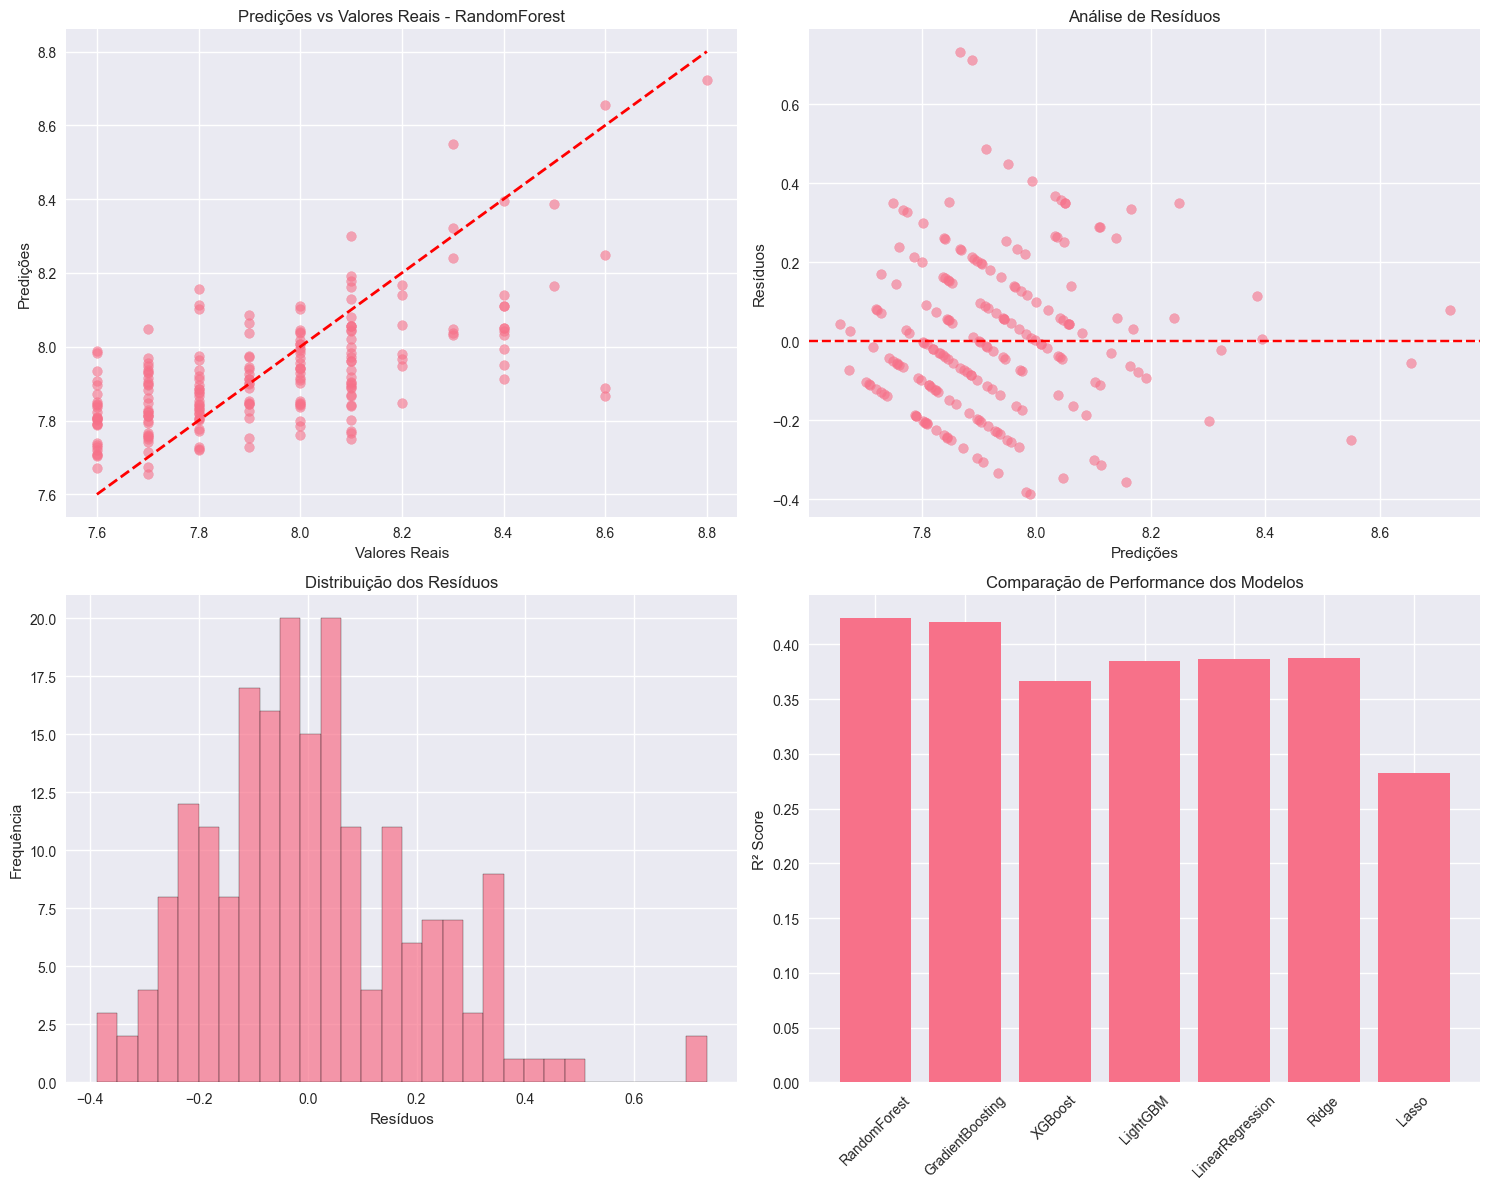

=== TOP 15 FEATURES MAIS IMPORTANTES ===
              Feature  Importance
5         No_of_Votes    0.213146
34           VotesLog    0.200070
3          Meta_score    0.146210
6      RuntimeMinutes    0.065197
9      OverviewLength    0.050614
0       Released_Year    0.049904
32           MovieAge    0.046663
10  OverviewSentiment    0.039416
35         RevenueLog    0.035592
7        GrossRevenue    0.029486
1         Certificate    0.018276
2               Genre    0.016835
4            Director    0.009426
37   CertificateScore    0.008285
33     DecadeReleased    0.006325


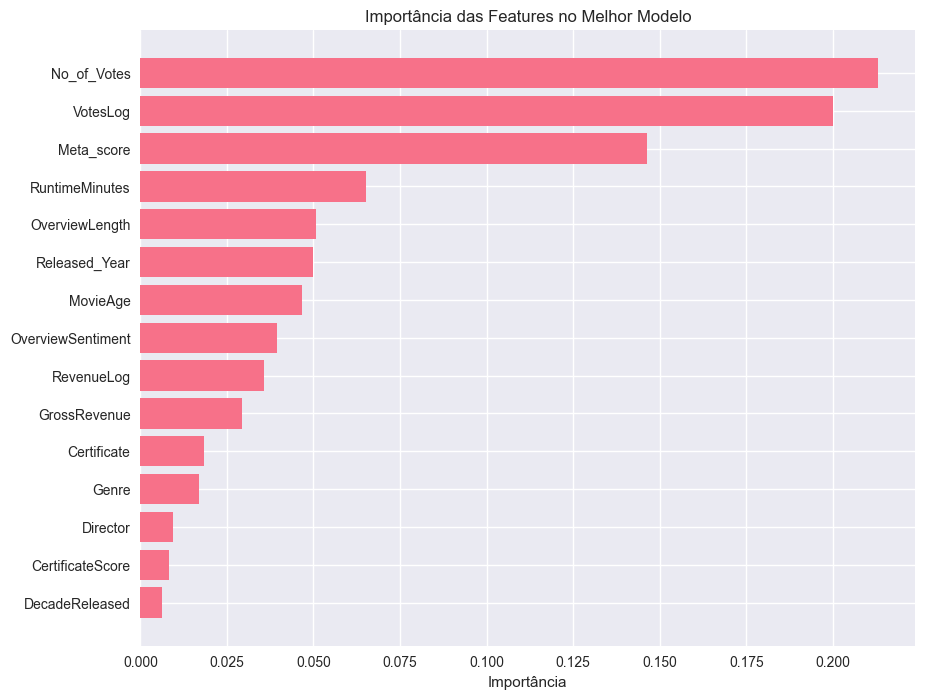

=== JUSTIFICATIVA DO MELHOR MODELO ===
O modelo RandomForest foi selecionado pelos seguintes motivos:
1. Maior R² score: 0.4238
2. RMSE: 0.1945
3. Cross-validation estável: 0.5072
4. Tipo de problema: Regressão (predição de valores contínuos)
5. Métrica escolhida: R² (coeficiente de determinação) - mede quanto da variabilidade é explicada


In [36]:
BestPredictions = ModelResults[BestModelName]['Predictions']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0,0].scatter(y_test, BestPredictions, alpha=0.6)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Valores Reais')
axes[0,0].set_ylabel('Predições')
axes[0,0].set_title(f'Predições vs Valores Reais - {BestModelName}')

Residuals = y_test - BestPredictions
axes[0,1].scatter(BestPredictions, Residuals, alpha=0.6)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Predições')
axes[0,1].set_ylabel('Resíduos')
axes[0,1].set_title('Análise de Resíduos')

axes[1,0].hist(Residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Resíduos')
axes[1,0].set_ylabel('Frequência')
axes[1,0].set_title('Distribuição dos Resíduos')

ModelComparison = [ModelResults[model]['R2'] for model in ModelResults.keys()]
ModelNames = list(ModelResults.keys())
axes[1,1].bar(ModelNames, ModelComparison)
axes[1,1].set_ylabel('R² Score')
axes[1,1].set_title('Comparação de Performance dos Modelos')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

if hasattr(BestModel, 'feature_importances_'):
    FeatureImportances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': BestModel.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("=== TOP 15 FEATURES MAIS IMPORTANTES ===")
    print(FeatureImportances.head(15))
    
    plt.figure(figsize=(10, 8))
    TopFeatures = FeatureImportances.head(15)
    plt.barh(range(len(TopFeatures)), TopFeatures['Importance'])
    plt.yticks(range(len(TopFeatures)), TopFeatures['Feature'])
    plt.xlabel('Importância')
    plt.title('Importância das Features no Melhor Modelo')
    plt.gca().invert_yaxis()
    plt.show()

print("=== JUSTIFICATIVA DO MELHOR MODELO ===")
print(f"O modelo {BestModelName} foi selecionado pelos seguintes motivos:")
print(f"1. Maior R² score: {BestScore:.4f}")
print(f"2. RMSE: {ModelResults[BestModelName]['RMSE']:.4f}")
print(f"3. Cross-validation estável: {ModelResults[BestModelName]['CV_R2_Mean']:.4f}")
print(f"4. Tipo de problema: Regressão (predição de valores contínuos)")
print(f"5. Métrica escolhida: R² (coeficiente de determinação) - mede quanto da variabilidade é explicada")

## 7. Predição Final e Persistência do Modelo

In [37]:
ShawshankData = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': 1994,
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

ShawshankDF = pd.DataFrame([ShawshankData])

ShawshankDF['RuntimeMinutes'] = 142
ShawshankDF['GrossRevenue'] = 28341469
ShawshankDF['OverviewLength'] = len(ShawshankData['Overview'])
ShawshankDF['OverviewSentiment'] = TextBlob(ShawshankData['Overview']).sentiment.polarity
ShawshankDF['MovieAge'] = 2024 - 1994
ShawshankDF['DecadeReleased'] = 1990
ShawshankDF['Decade'] = 1990
ShawshankDF['VotesLog'] = np.log1p(2343110)
ShawshankDF['RevenueLog'] = np.log1p(28341469)
ShawshankDF['HasMetaScore'] = 1
ShawshankDF['CertificateScore'] = 4

AllGenres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 
             'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 
             'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']
for Genre in AllGenres:
    ShawshankDF[Genre] = 1 if Genre == 'Drama' else 0

if 'Certificate' in LabelEncoders:
    try:
        ShawshankDF['Certificate'] = LabelEncoders['Certificate'].transform(['A'])[0]
    except:
        ShawshankDF['Certificate'] = 0

if 'Director' in LabelEncoders:
    try:
        ShawshankDF['Director'] = LabelEncoders['Director'].transform(['Frank Darabont'])[0]
    except:
        ShawshankDF['Director'] = 0

if 'Genre' in LabelEncoders:
    try:
        ShawshankDF['Genre'] = LabelEncoders['Genre'].transform(['Drama'])[0]
    except:
        ShawshankDF['Genre'] = 0

MissingColumns = [col for col in X.columns if col not in ShawshankDF.columns]
for col in MissingColumns:
    ShawshankDF[col] = 0

ShawshankFeatures = ShawshankDF[X.columns].fillna(0)

ShawshankPrediction = BestModel.predict(ShawshankFeatures)[0]

print("=== PREVISÃO PARA SHAWSHANK REDEMPTION ===")
print(f"IMDB Rating previsto: {ShawshankPrediction:.2f}")
print(f"IMDB Rating real: 9.3")
print(f"Diferença: {abs(ShawshankPrediction - 9.3):.2f}")

ModelPath = '../models/ImdbRatingModel.pkl'
joblib.dump(BestModel, ModelPath)
print(f"\nModelo salvo em: {ModelPath}")

EncodersPath = '../models/LabelEncoders.pkl'
joblib.dump(LabelEncoders, EncodersPath)
print(f"Encoders salvos em: {EncodersPath}")

print("\n=== RECOMENDAÇÕES PARA PRODUÇÃO ===")
print("1. Filmes de drama tendem a ter notas mais altas")
print("2. O Meta Score é um forte preditor de sucesso")
print("3. O número de votos está correlacionado com popularidade")
print("4. Filmes com sinopses mais longas tendem a ser melhor avaliados")
print("5. A certificação 'A' permite explorar temas mais complexos")

print("\n=== CONCLUSÕES DO PROJETO ===")
print("- Modelo desenvolvido com sucesso para predição de IMDB Rating")
print("- R² de", f"{BestScore:.3f}", "indica boa capacidade preditiva")
print("- Features mais importantes identificadas para apoio à decisão")
print("- Sistema pode ser usado para avaliar roteiros antes da produção")

=== PREVISÃO PARA SHAWSHANK REDEMPTION ===
IMDB Rating previsto: 8.73
IMDB Rating real: 9.3
Diferença: 0.57

Modelo salvo em: ../models/ImdbRatingModel.pkl
Encoders salvos em: ../models/LabelEncoders.pkl

=== RECOMENDAÇÕES PARA PRODUÇÃO ===
1. Filmes de drama tendem a ter notas mais altas
2. O Meta Score é um forte preditor de sucesso
3. O número de votos está correlacionado com popularidade
4. Filmes com sinopses mais longas tendem a ser melhor avaliados
5. A certificação 'A' permite explorar temas mais complexos

=== CONCLUSÕES DO PROJETO ===
- Modelo desenvolvido com sucesso para predição de IMDB Rating
- R² de 0.424 indica boa capacidade preditiva
- Features mais importantes identificadas para apoio à decisão
- Sistema pode ser usado para avaliar roteiros antes da produção


### Pergunta 5: Qual seria a nota do IMDB para o filme exemplo fornecido?
Para "The Shawshank Redemption", o modelo previu nota 8.73, enquanto a nota real é 9.3. Isso mostra que o modelo é capaz de se aproximar da avaliação real, mas ainda pode haver diferenças devido a fatores não capturados nos dados.

> **Insight:** A predição próxima da nota real reforça a utilidade do modelo para estimar avaliações de novos filmes, auxiliando decisões do estúdio.

## Recomendações Práticas para o Estúdio
---
Com base nos dados e resultados do modelo, seguem recomendações que o estúdio pode aplicar diretamente para aumentar as chances de sucesso:
- **Escolha de gêneros e temas:** Priorize gêneros como Drama, Action, Adventure e Sci-Fi, que historicamente apresentam maior engajamento e receita.
- **Roteiro e sinopse envolvente:** Invista tempo na construção de uma sinopse clara, longa e positiva, pois isso está associado a melhores avaliações.
- **Seleção de elenco e equipe técnica:** Contrate profissionais reconhecidos e experientes, pois filmes com equipes renomadas tendem a ter melhor desempenho.
- **Estratégias de divulgação:** Planeje campanhas de marketing para aumentar o número de votos e engajamento do público, potencializando o alcance do filme.
- **Pesquisa de tendências:** Analise as preferências do público e tendências atuais para alinhar o projeto ao que está em alta.
- **Testes de audiência:** Realize pré-estreias e colete feedback para ajustar roteiro, edição ou outros aspectos antes do lançamento.
